# Single-excitation subspace approximation
In order to achieve numerical convergence for resonant RC modes, we may need to reduce the size of the state space. One way of achieving this is by simply **removing the doubly excited state in the dimer** - for **large enough system energies** this is likely to be valid. I can then check whether this has an impact on the figures of merit that we're interested in (electronic coherence) by checking that it matches the full model - in a fortuitous parameter regime or by comparing the non-converged version. Once we know that the approximation can be made, we can then check to see if it improves convergence. If it doesn't get us the whole way there, then we can think about doing a (dodgy) mapping to a spin-boson model (with added ground state).



- Check validity of approximation without phonons
- Make the approximation and tweak the code to make sure it gives agreement to full in relevant regimes (with phonons). also Find regimes where the approximation breaks down.
- Check to see if the approximation improves convergence
- If convergence isn't improved then do the dodgy mapping

In [45]:
import os

import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import phonons as RC
import optical as opt
import time
import phonons
#from phonons import RC_mapping
from optical import L_non_rwa, L_phenom
from qutip import basis, qeye, enr_identity, enr_destroy, tensor, enr_thermal_dm, steadystate, Qobj
from utils import *
import tests as check

OO = basis(3,0)
XO = basis(3,1)
OX = basis(3,2)


site_coherence = OX*XO.dag()

OO_p = OO*OO.dag()
XO_p = XO*XO.dag()
OX_p = OX*OX.dag()

sigma_m1 =  OO*XO.dag()
sigma_m2 =  OO*OX.dag()
sigma_x1 = sigma_m1+sigma_m1.dag()
sigma_x2 = sigma_m2+sigma_m2.dag()

I_dimer = qeye(3)

reload(RC)
reload(opt)

<module 'optical' from 'optical.pyc'>

# Checking if SES approximation is valid

In [2]:
def plot_optical_dynamics(bias=100., w_2=2000., V = 100., w_b=100.
                        ,T_EM=0., alpha_EM=1., double=True
                        ,dimer_init='one'):
    w_1 = w_2 + bias
    if double:
        OO = basis(4,0)
        XO = basis(4,1)
        OX = basis(4,2)
        XX = basis(4,3)
        
        w_xx = w_2 + w_1+w_b
        H_dim_sub = w_1*XO*XO.dag()
        H_dim_sub += w_2*OX*OX.dag() + w_xx*XX*XX.dag()
        H_dim_sub += V*(XO*OX.dag() + OX*XO.dag())
        XX_p = XX*XX.dag()
        sigma_m1 = OX*XX.dag() + OO*XO.dag()
        sigma_m2 = XO*XX.dag() + OO*OX.dag()
        
    else:
        OO = basis(3,0)
        XO = basis(3,1)
        OX = basis(3,2)
        H_dim_sub = w_1*XO*XO.dag()
        H_dim_sub += w_2*OX*OX.dag()
        H_dim_sub += V*(XO*OX.dag() + OX*XO.dag())
        sigma_m1 = OO*XO.dag()
        sigma_m2 = OO*OX.dag()
    
    OO_p = OO*OO.dag()
    XO_p = XO*XO.dag()
    OX_p = OX*OX.dag()
        
    sigma_x1d = sigma_m1+sigma_m1.dag()
    sigma_x2d = sigma_m2+sigma_m2.dag()
    
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    
    num_cpus = 1
    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias',
                   'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2',]
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    

    '''Defining DM states'''
    site_coherence = OX*XO.dag()
    
    #Now we build all of the mapped operators and RC Liouvillian.

    # electromagnetic bath liouvillians

    opts = qt.Options(num_cpus=1, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    ''' generate the RC liouvillian '''
    """L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                            silent=False, 
                                                            shift=True) # Get the mapped parameters back"""
    #H_dim = w_1*XO*XO.dag() + w_2*OX*OX.dag() + w_xx*XX*XX.dag() + V*(XO*OX.dag() + OX*XO.dag())
    import utils as ut
    reload(ut)
    energies, states = ut.exciton_states(PARAMS, shift=False)
    bright_vec = states[1]
    dark_vec = states[0]
    if not double:
        bright_vec = bright_vec.eliminate_states([3])
        dark_vec = dark_vec.eliminate_states([3])
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    exciton_coherence = dark_vec*bright_vec.dag()
    
    
    opts = qt.Options(num_cpus=num_cpus, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    
    if dimer_init=='one':
        rho_0 = XO_p
    elif dimer_init in ('zero', 'ground'):
        rho_0 = OO_p
    elif dimer_init=='bright':
        rho_0 = bright
    elif dimer_init=='dark':
        rho_0 = dark
    elif dimer_init== 'exc_coherence':
        rho_0 = 0.5*(dark_vec*bright_vec.dag()+bright_vec*dark_vec.dag())
    else:
        print "The {} descriptor for electronic state is not an option".format(dimer_init)
        raise ValueError
    #timelist = np.linspace(0,3,1000)
    e_ops = [XO_p, exciton_coherence, dark, bright]
    timelist = np.linspace(0,2.0,10000)
    options = qt.solver.Options(nsteps=1500)
    print bright
    L_EM_full = L_non_rwa(H_dim_sub, sigma, PARAMS, silent=True)
    ti = time.time()
    data_f = qt.mesolve(H_dim_sub, rho_0, timelist, c_ops=L_EM_full, 
                        e_ops=e_ops, options=options)
    
    print "full dynamics took {:0.3f} seconds".format(time.time()-ti)
    
    ti = time.time()
    L_EM_s = opt.L_secular(H_dim_sub, sigma, PARAMS, silent=True)
    
    data_s = qt.mesolve(H_dim_sub, rho_0, timelist, c_ops=L_EM_s, 
                        e_ops=e_ops, options=options)
    print "additive dynamics took {:0.3f} seconds".format(time.time()-ti)
    
    return data_f, data_s, timelist

bias = 100.
w_2 = 2.0 # eV
V = 200.
w_b = V
T = 6000.
initial = 'zero'
data_fd, data_sd, timelist = plot_optical_dynamics(bias=bias, w_2=8000.*w_2, V = V, w_b=w_b
                        ,T_EM=T, alpha_EM=1., double=True
                        ,dimer_init=initial)
data_f, data_s, timelist = plot_optical_dynamics(bias=bias, w_2=8000.*w_2, V = V, w_b=w_b
                        ,T_EM=T, alpha_EM=1., double=False
                        ,dimer_init=initial)



Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.62126781  0.48507125  0.        ]
 [ 0.          0.48507125  0.37873219  0.        ]
 [ 0.          0.          0.          0.        ]]
full dynamics took 9.565 seconds

additive dynamics took 0.619 seconds
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.          0.62126781  0.48507125]
 [ 0.          0.48507125  0.37873219]]
full dynamics took 0.591 seconds

additive dynamics took 0.575 seconds


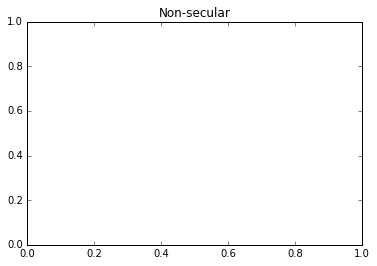

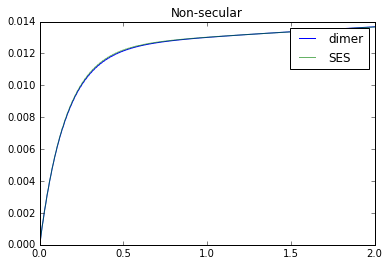

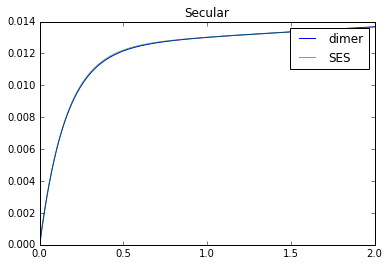

In [8]:
expval = 0
plt.figure()
plt.title("Non-secular")
plt.plot(timelist, data_fd.expect[expval].real, label='dimer')
plt.plot(timelist, data_f.expect[expval].real, label='SES', alpha=0.6)
plt.legend()
plt.figure()
plt.title("Secular")
plt.plot(timelist, data_sd.expect[expval].real, label='dimer')
plt.plot(timelist, data_s.expect[expval].real, label='SES', alpha=0.6)
plt.legend()
plt.show()

It appears that although the populations are recreated very well for larger system energies, the SES model does not like the exciton coherences. It seems like this could be a numerical problem, though I cannot work out its cause right now. Could there be **some component of the coherence  due to the doubly-excited state?** The next step could be to check if this is the case when adding in phonons as well. **It could be some problem with the non-RWA code and the way the operators are defined.**

## Mapping and Liouvillian code
Adapted from dimer code to accept general system Hamiltonians, just need to define system-coupling operators for each bath: $|X0><X0|$ and $|0X><0X|$, defined as `CO1` and `CO2` respectively.

In [2]:
def ham_RC(H, CO1, CO2, COEM, 
           Omega_1, Omega_2, 
           kap_1, kap_2,
           N_1, N_2, exc):
    """ Builds RC Hamiltonian in excitation restricted subspace

    Input: System splitting, RC freq., system-RC coupling
    and Hilbert space dimension Output: Hamiltonian, all
    collapse operators in the vibronic Hilbert space
    """
    
    #I_RC_1 = qeye(N_1)
    #I_RC_2 = qeye(N_2)
    I_dim = qeye(H.shape[0])
    I = enr_identity([N_1,N_2], exc)
    shift1, shift2 = (kap_1**2)/Omega_1, (kap_2**2)/Omega_2
    H_sub = H
    
    H_sub += shift1*(CO1*CO1)
    H_sub += shift2*(CO2*CO2)
    
    #shift1, shift2 = (kap_1**2)/Omega_1, (kap_2**2)/Omega_2
    #print H_dim_sub
    H_RC = tensor(H_sub, I)

    atemp = enr_destroy([N_1,N_2], exc)

    a_RC_exc = [tensor(I_dim, aa) for aa in atemp] # annhilation ops in exc restr basis
    A_1 = a_RC_exc[0].dag() + a_RC_exc[0]
    A_2 = a_RC_exc[1].dag() + a_RC_exc[1]
    H_I1 = kap_1*tensor(CO1, I)*A_1
    H_I2 = kap_2*tensor(CO2, I)*A_2

    H_RC1 = Omega_1*a_RC_exc[0].dag()*a_RC_exc[0]
    H_RC2 = Omega_2*a_RC_exc[1].dag()*a_RC_exc[1]

    H_S = H_RC + H_RC1 + H_RC2 + H_I1 + H_I2
    return [H_sub, H_S], A_1, A_2, tensor(COEM, I)


def RC_mapping(H_sub, CO1, CO2, COEM, args, silent=False):

    # we define all of the RC parameters by the underdamped spectral density
    T_1, T_2 = args['T_1'], args['T_2']
    wRC_1, wRC_2, alpha_1, alpha_2= args['w0_1'], args['w0_2'], args['alpha_1'], args['alpha_2']
    N_1, N_2, exc = args['N_1'], args['N_2'], args['exc']
    Gamma_1, Gamma_2 = args['Gamma_1'], args['Gamma_2']
    gamma_1 = Gamma_1 / (2. * np.pi * wRC_1)
    kappa_1 = np.sqrt(np.pi * alpha_1 * wRC_1 / 2.)  # coupling strength between the TLS and RC

    gamma_2 = Gamma_2 / (2. * np.pi * wRC_2)
    kappa_2 = np.sqrt(np.pi * alpha_2 * wRC_2 / 2.)
    args.update({'gamma_1': gamma_1, 'gamma_2': gamma_2, 'w0_1': wRC_1,
                    'w0_2': wRC_2, 'kappa_1':kappa_1, 'kappa_2':kappa_2})
    #print args
    H, A_1, A_2, COEM_RC = ham_RC(H_sub, CO1, CO2, COEM, wRC_1, wRC_2, kappa_1, kappa_2, N_1, N_2, exc)
    L_RC =  phonons.liouvillian_build(H[1], A_1, A_2, gamma_1, gamma_2,  wRC_1, wRC_2,
                            T_1, T_2, num_cpus=args['num_cpus'], silent=silent)
    full_size = (H_sub.shape[0]*N_1*N_2)**2
    if not silent:
        print "****************************************************************"
        note = (L_RC.shape[0], L_RC.shape[0], full_size, full_size)
        print "It is {}by{}. The full basis would be {}by{}".format(L_RC.shape[0],
                                            L_RC.shape[0], full_size, full_size)
    return -L_RC, H, A_1, A_2, COEM_RC, args

In [3]:
def H_sub(w_2, bias, V):
    w_1 = w_2 + bias
    H_dim_sub = w_1*XO*XO.dag()
    H_dim_sub += w_2*OX*OX.dag()
    H_dim_sub += V*(XO*OX.dag() + OX*XO.dag())
    return H_dim_sub
def energy_gap(bias, V):
    return sqrt(bias**2 + (4*V)**2)

In [213]:
def plot_opt_and_phonon_dynamics(bias=100., w_2=2000., V = 100., w_b=100.
                        ,T_EM=0., alpha_EM=1., N=3, alpha_1=100., alpha_2=100., Gamma = 50.,
                        T_ph =300., Omega=None, shift=True, double=True, dimer_init='one'):
    w_1 = w_2 + bias
    T_1 = T_2 = T_ph
    N_1 = N_2 = N
    exc = N
    if double:
        OO = basis(4,0)
        XO = basis(4,1)
        OX = basis(4,2)
        XX = basis(4,3)
        
        w_xx = w_2 + w_1 + w_b
        H_dim_sub = w_1*XO*XO.dag()
        H_dim_sub += w_2*OX*OX.dag() + w_xx*XX*XX.dag()
        H_dim_sub += V*(XO*OX.dag() + OX*XO.dag())
        XX_p = XX*XX.dag()
        sigma_m1 = OX*XX.dag() + OO*XO.dag()
        sigma_m2 = XO*XX.dag() + OO*OX.dag()
        I_dimer = qeye(4)
    else:
        OO = basis(3,0)
        XO = basis(3,1)
        OX = basis(3,2)
        H_dim_sub = w_1*XO*XO.dag()
        H_dim_sub += w_2*OX*OX.dag()
        H_dim_sub += V*(XO*OX.dag() + OX*XO.dag())
        sigma_m1 = OO*XO.dag()
        sigma_m2 = OO*OX.dag()
        I_dimer = qeye(3)
    Gamma_1, Gamma_2 = Gamma, Gamma
    w0_2, w0_1 = Omega, Omega # underdamped SD parameter omega_0
    print "|\t Energy gap is {} \t | \t RC freq is {} \t |".format(energy_gap(bias, V), w0_1)
    I = enr_identity([N_1,N_1], exc)
    OO_p = OO*OO.dag()
    XO_p = XO*XO.dag()
    OX_p = OX*OX.dag()
        
    sigma_x1d = sigma_m1+sigma_m1.dag()
    sigma_x2d = sigma_m2+sigma_m2.dag()
    
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    
    num_cpus = 1
    J = J_minimal
    wc = 0.
    PARAM_names = [ 'w_1', 'bias', 'w_2', 'V', 'T_1', 'T_2', 'wc',
                   'w0_1', 'w0_2', 'alpha_1', 'alpha_2', 'N_1', 'N_2', 'exc', 
                   'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    

    '''Defining DM states'''
    site_coherence = OX*XO.dag()
    
    #Now we build all of the mapped operators and RC Liouvillian.

    # electromagnetic bath liouvillians

    opts = qt.Options(num_cpus=1, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    ''' generate the RC liouvillian '''
    L_RC, H, A_1, A_2, COEM_RC, PARAMS = RC_mapping(H_dim_sub, XO_p, OX_p, sigma, PARAMS, silent=False)
    # Get the mapped parameters back
    import utils as ut
    reload(ut)
    energies, states = ut.exciton_states(PARAMS, shift=False)
    bright_vec = states[1]
    dark_vec = states[0]
    if not double:
        bright_vec = bright_vec.eliminate_states([3])
        dark_vec = dark_vec.eliminate_states([3])
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    exciton_coherence = dark_vec*bright_vec.dag()
    
    
    opts = qt.Options(num_cpus=num_cpus, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    
    if dimer_init=='one':
        rho_i = XO_p
    elif dimer_init in ('zero', 'ground'):
        rho_i = OO_p
    elif dimer_init =='bright':
        rho_i = bright
    elif dimer_init =='dark':
        rho_i = dark
    elif dimer_init == 'exc_coherence':
        rho_i = 0.5*(dark_vec*bright_vec.dag()+bright_vec*dark_vec.dag())
    else:
        print "The {} descriptor for electronic state is not an option".format(dimer_init)
        raise ValueError
    n_RC_1 = Occupation(w0_1, T_1)
    n_RC_2 = Occupation(w0_2, T_2)
    thermal_RCs = enr_thermal_dm([N_1, N_2], exc, [n_RC_1, n_RC_2])
    rho_0 = tensor(rho_i, thermal_RCs)
    #timelist = np.linspace(0,3,1000)
    e_ops = [tensor(op,I) for op in [XO_p, exciton_coherence, dark, bright]]
    timelist = np.linspace(0,2.0,10000)
    options = qt.solver.Options(nsteps=1500)
    #L_EM_full = L_non_rwa(H[1], COEM_RC, PARAMS, silent=True)
    
    ti = time.time()
    data_f = qt.mesolve(H[1], rho_0, timelist, c_ops=L_RC, 
                        e_ops=e_ops, options=options, progress_bar=True)
    
    print "full dynamics took {:0.3f} seconds".format(time.time()-ti)
    
    """ti = time.time()
    L_EM_s = opt.L_nonsecular(H[0], sigma, PARAMS, silent=True)
    
    data_s = qt.mesolve(H[0], rho_0, timelist, c_ops=L_EM_s, 
                        e_ops=e_ops, options=options)
    print "additive dynamics took {:0.3f} seconds".format(time.time()-ti)"""
    
    return data_f, timelist





In [ ]:
bias = 0.
w_2 = 2000. # eV
V = 1500.
w_b = V
T = 0.
N = 5
initial = 'zero'
"""data_fd, timelist = plot_opt_and_phonon_dynamics(bias=bias, w_2=w_2*8000, V = V, w_b=w_b
                        ,T_EM=T, alpha_EM=1., N=N, alpha_1=300., alpha_2=500., 
                        T_ph =300., shift=True, double=True, dimer_init='one')"""
data_f , timelist = plot_opt_and_phonon_dynamics(bias=bias, w_2=2000., V = V, w_b=w_b
                        ,T_EM=T, alpha_EM=0., N=N, alpha_1=800., alpha_2=800., 
                        T_ph =300., shift=True, double=False, dimer_init='one')

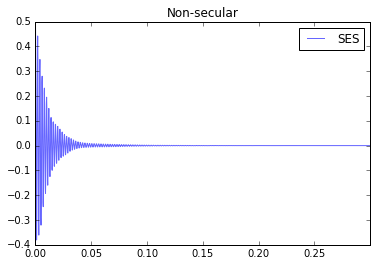

In [130]:
expval = 1
plt.figure()
plt.title("Non-secular")
#plt.plot(timelist, data_fd.expect[expval].real, label='dimer')
plt.plot(timelist, data_f.expect[expval].real, label='SES', alpha=0.6)
plt.legend()
plt.xlim(0,0.3)
plt.show()

In [2]:
n = iter(range(5,8))
lab = ['full', 'add. ns', 'add']

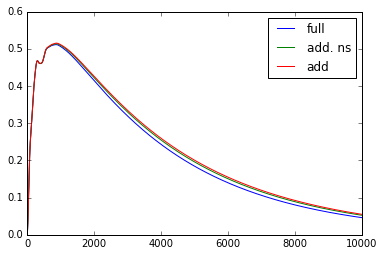

In [140]:

"""for d in dat:
    
    for i, l in enumerate(d):
        plt.plot(l.expect[1].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend(loc='best')"""
plt.figure()
for d in dat1:
    for i, l in enumerate(d):
        plt.plot(l.expect[4].real, label=lab[i])
        #plt.plot(l.expect[0].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend(loc='best')
plt.show()

## Convergence tests
THis is to ask the question: **does making the SES approx reduce the state space enough to get convergence?**

I need to see (for a few different system parameter regimes and $\omega_0$, how well converged the steady states are. parameters I will test are: 

$\omega_2/\omega_0 =5, 20$

$\pi\alpha_{ph} = 0.005\omega_2, 0.1\omega_2, 0.2\omega_2, 0.5\omega_2$

Test between 5, 9: 5 combinations



In [5]:
def convergence(bias=100., w_2=2000., V = 100., pialpha_prop=0.1,
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=5, upper_N=9, 
                                 num_cpus=1, w_0=None):
    
    phonon_energy = T_ph*0.695
    gap = energy_gap(bias, V)
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = T_ph, T_ph # Phonon bath temperature
    
    Gamma_1, Gamma_2 = 50., 50.
    if w_0 == None:
        w0_2, w0_1 = gap+30, gap+30 # underdamped SD parameter omega_0
        upper_N = upper_N #N_across_gap(w_2, gap)
    else:
        w0_2, w0_1 = w_0, w_0 # underdamped SD parameter omega_0
        upper_N = upper_N
    
    w_xx = w_2 + w_1
    print "| Gap is {} \t | \t Phonon thermal energy is {}\t | \t Phonon SD peak is {} |".format(gap, 
                                                                                 phonon_energy, w0_2)
    I_dimer = qeye(4)

    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'T_1', 'T_2',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    '''Defining DM states'''
    

    #Now we build all of the mapped operators and RC Liouvillian.
    
    # electromagnetic bath liouvillians
    N_vals = range(lower_N, upper_N+1)[::-1]
    print N_vals
    steady_states = []
    
    for i, N in enumerate(N_vals):
        alpha = w_2*pialpha_prop/pi
        N_1 = N_2 = N
        exc = N
        
        silent = False
        if N<=5:
            silent = True
        
        PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
        PARAMS.update({'N_1': N_1, 'N_2': N_2})
        PARAMS.update({'exc': exc})
        I = enr_identity([N_1,N_2], exc)
        ''' generate the RC liouvillian '''
        # Get the mapped parameters back
        L_RC, H, A_1, A_2, COEM_RC, PARAMS = RC_mapping(H_sub(w_2, bias, V), XO_p, OX_p,
                                                        sigma, PARAMS, silent=False)
        
        L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
        ti = time.time()
        L = L_RC+L_EM_full
        if N >5:
            print i+1, " N=",N
            method='iterative-lgmres'
            use_precond = True
            ff=100
            dt=1e-4
            if N>7:
                ff = 70
                dt = 1e-3
                """
                if N>8:
                    ff = 50
                    dt = 5e-2"""
        else:
            method = 'direct'
            use_precond = False
            ff=100
            dt=1e-4
        ss = steadystate(H[1], [L], method=method, use_precond=use_precond,
                                                 fill_factor=ff, drop_tol=dt)
        steady_states.append(ss)
        if not silent:
            print "full steady states took {:0.3f} seconds".format(time.time()-ti)
    j = 1
    saved = False
    while not saved:
        directory = 'DATA/SESconvergence_'+str(j)
        if not os.path.exists(directory):
            os.makedirs(directory)
            save_obj(steady_states, directory+'/steady_states')
            save_obj(PARAMS, directory+'/PARAMS')
            save_obj(N_vals, directory+'/N_vals')
            saved = True
        else:
            j+=1

            
def convergence_plotter(num):
    directory = 'DATA/SESconvergence_'+str(num)
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')  # reverse ordering -> lower_N-higher_N
    
    energies, states = exciton_states(PARAMS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    e_ops = [OO_p, XO_p, OX_p, site_coherence]
    expectation_values = []
    for e_op in e_ops:
        dat = []
        for i, ss in enumerate(steady_states):
            I = enr_identity([N_vals[i],N_vals[i]], N_vals[i])
            dat.append((tensor(e_op,I)*ss).tr())    
        expectation_values.append(dat)
    
    ''' make the RC observable operators '''
    
    
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['0' '1', '2']
    ids = [0,1,2]
    for i, l in zip(ids, labels):
        plt.plot(N_vals[::-1], np.array(expectation_values[i]).real[::-1], label=l, color=colors[i])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(r'Population')
    plt.legend()
    
    plt.figure()
    plt.plot(N_vals[::-1], np.array(expectation_values[3]).real[::-1], label='real', color=colors[0])
    plt.plot(N_vals[::-1], np.array(expectation_values[3]).imag[::-1], label='imag', color=colors[1])
    plt.xlabel(r'N')
    plt.ylabel(r'Site coherence')
    plt.legend()
    plt.show()
    
    return N_vals, expectation_values


In [6]:
V = 200.
bias=100.
convergence(bias=bias, w_2=2000., V = V, pialpha_prop=0.05,
                                 T_EM=1000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=5, upper_N=9, 
                                 num_cpus=3, w_0=None)
convergence(bias=bias, w_2=8000., V = V, pialpha_prop=0.05,
                                 T_EM=1000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=5, upper_N=9, 
                                 num_cpus=3, w_0=None)
"""convergence(bias=bias, w_2=2000., V = V, pialpha_prop=0.2,
                                 T_EM=1000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=3, upper_N=8, 
                                 num_cpus=1, w_0=None)
convergence(bias=bias, w_2=2000., V = V, pialpha_prop=0.1,
                                 T_EM=1000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=3, upper_N=8, 
                                 num_cpus=1, w_0=None)
convergence(bias=bias, w_2=2000., V = V, pialpha_prop=0.05,
                                 T_EM=1000., T_ph =800., 
                                 alpha_EM=1., shift=True,
                                 lower_N=2, upper_N=8, 
                                 num_cpus=1, w_0=None)"""


| Gap is 806.22577483 	 | 	 Phonon thermal energy is 208.5	 | 	 Phonon SD peak is 836.22577483 |
[9, 8, 7, 6, 5]
The operators took 31.4586560726 and have dimension 159.
Building the RC Liouvillian took 31.482 seconds.
****************************************************************
It is 25281by25281. The full basis would be 59049by59049
Full optical Liouvillian took 56.0128591061 seconds.
1  N= 9


Exception: Steadystate error: Did not reach tolerance after 1000 steps.
Residual norm: None

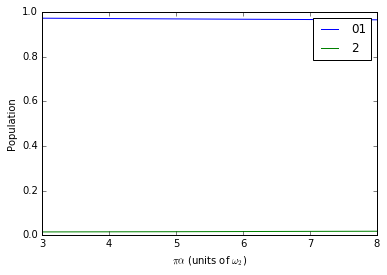

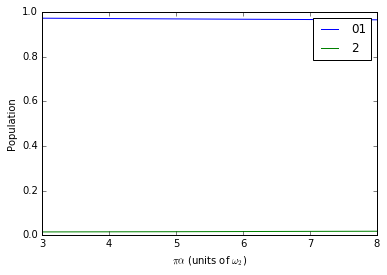

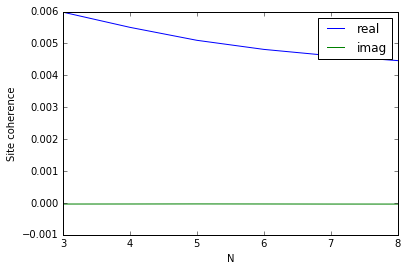

'N_vals_c, exp_vals = convergence_plotter(12)\nN_vals_c, exp_vals = convergence_plotter(13)\nN_vals_c, exp_vals = convergence_plotter(14)'

In [179]:
N_vals_c, exp_vals = convergence_plotter(1)
"""N_vals_c, exp_vals = convergence_plotter(12)
N_vals_c, exp_vals = convergence_plotter(13)
N_vals_c, exp_vals = convergence_plotter(14)"""

# Spin-boson mapping

Here I will calculate the model (in absence of optical field) via mapping it to the spin-boson model. This is a stepping stone to see if the spin-boson model plus some ground state can approximate the optical field case. The spin-boson model is

$\frac{\epsilon}{2}\sigma_z + \frac{\Delta}{2}\sigma_x + \sigma_z\sum_k g_k(b_k + b_k^{\dagger}) + \sum_k\omega_k b_k^{\dagger}b_k$

where, assuming that both baths are identical, $\epsilon=\epsilon^{\prime}_1-\epsilon^{\prime}_2$, $\Delta = 2V$ and $g_k = \frac{1}{2}\sqrt{u_k^2 + v_k^2}$ so the new spectral density is $J_{eff}(\omega)  = \frac{1}{4}(J_1(\omega) + J_2(\omega))$ where the latter are the spectral densities for the phonon bath at each site. The RC mapping is only really valid for Lorentzians and not double-Lorentzians, so we'll take the case where $J_1(\omega) = J_2(\omega)$.

### Which code do I use to calculate the dynamics?
I should just use the monomer code I think, I hope this has been generalised to take in any system Hamiltonian rather than just the independent boson model.

In [104]:
# Import the monomer code

import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        pass
        #sys.path.remove(self.path)

with add_path('/Users/henrymaguire/Work/phd-work/TLS-code'):
    monRC = __import__("UD_liouv")

monRC.RC_function_gen


<function UD_liouv.RC_function_gen>

In [216]:
reload(monRC)

def spin_boson_mapped_dynamics(bias=0., eps_2=2000., V=150.,
                               alpha=50., Omega=200., Gamma=40., 
                               T_ph=300., N=5):
    eps_1 = eps_2 + bias
    shifted_bias = bias
    one = basis(2,1)
    two = basis(2,0)
    sigma_z = -two*two.dag() + one*one.dag()
    sigma_x = two*one.dag() + one*two.dag()
    H_sub = shifted_bias*sigma_z + 2*V*sigma_x
    sigma = two*one.dag()
    XO_p = one*one.dag()
    OX_p = two*two.dag()
    I = qeye(N)
    L_RC, H, A_em, A_nrwa, Z, wRC, kappa, Gamma = monRC.RC_function_gen(H_sub, sigma, T_ph,
                                                                        Gamma, Omega, alpha, N, 
                                                                        silent=False, residual_off=False, 
                                                                        rotating=False, shift=False,
                                                                        shift_op = sigma_z)
    print H.eigenenergies()
    PARAMS = {'w_1':eps_1, 'w_2':eps_2, 'bias':shifted_bias, 'V':V}
    print PARAMS
    energies, states = exciton_states(PARAMS, shift=False)
    bright_vec = states[1].eliminate_states([0,3])
    dark_vec = states[0].eliminate_states([0,3])
    exciton_coherence = dark_vec*bright_vec.dag()
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    f = lambda x: tensor(x, I)
    e_ops = map(f, [XO_p, OX_p, exciton_coherence, dark, bright])
    timelist = np.linspace(0,2.0,10000)
    options = qt.solver.Options(nsteps=1500)
    #L_EM_full = L_non_rwa(H_sub, sigma, PARAMS, silent=True)
    ti = time.time()
    rho_0 = tensor(XO_p, qt.thermal_dm(N, Occupation(Omega, T_ph)))
    data_f = qt.mesolve(H, rho_0, timelist, c_ops=L_RC, 
                        e_ops=e_ops, options=options)
    print('Finished')
    return timelist, data_f
bias = 0.
w_2 = 2000.
V = 150.
N = 10
T_ph = 300.
Gamma = 50.
Omega = 200.
alpha = 100.
timelist, data_f = spin_boson_mapped_dynamics(bias=bias, eps_2=w_2, V=V,
                               alpha=0.5*alpha, Omega=Omega, Gamma=Gamma, 
                               T_ph=T_ph, N=N)

w_RC=200.0 | RC-res. coupling=0.04 | TLS-RC coupling=125.33 | Gamma_RC=50.00 | alpha_ph=50.00 | N=10 |
[ -321.26787463  -174.32389935   -15.72683801   146.97458705   313.75536565
   332.68345367   483.86213104   573.35571867   657.99716036   802.14249303
   844.70242214  1015.87930732  1064.60785453  1259.91094632  1338.33245357
  1501.8711616   1739.94617492  1918.9744008   2225.76923762  2290.5537437 ]
{'V': 150.0, 'bias': 0.0, 'w_1': 2000.0, 'w_2': 2000.0}
Finished


In [218]:
w_b = 300.
fact = 1
data_fd , timelistd = plot_opt_and_phonon_dynamics(bias=bias, w_2=w_2, V = V, w_b=w_b
                        ,T_EM=0, alpha_EM=0., N=N-2, Gamma=Gamma, alpha_1=alpha*fact, alpha_2=alpha*fact, 
                        T_ph = T_ph, shift=True, double=False, dimer_init='one', Omega=Omega)

|	 Energy gap is 600.0 	 | 	 RC freq is 200.0 	 |
The operators took 44.3074400425 and have dimension 129.
Building the RC Liouvillian took 46.371 seconds.
****************************************************************
It is 16641by16641. The full basis would be 36864by36864
10.0%. Run time:  26.29s. Est. time left: 00:00:03:56
20.0%. Run time:  52.29s. Est. time left: 00:00:03:29
30.0%. Run time:  78.33s. Est. time left: 00:00:03:02
40.0%. Run time: 104.35s. Est. time left: 00:00:02:36
50.0%. Run time: 130.43s. Est. time left: 00:00:02:10
60.0%. Run time: 156.51s. Est. time left: 00:00:01:44
70.0%. Run time: 182.53s. Est. time left: 00:00:01:18
80.0%. Run time: 208.60s. Est. time left: 00:00:00:52
90.0%. Run time: 234.53s. Est. time left: 00:00:00:26
Total run time: 260.64s
full dynamics took 260.825 seconds


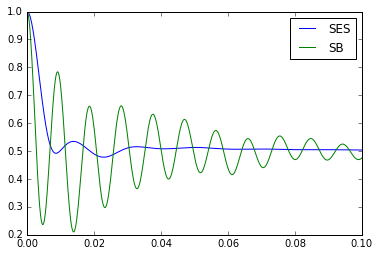

In [219]:
#plt.plot(timelist, data_f.expect[0], label='Site 1')
plt.plot(timelistd, data_fd.expect[0].real, label='SES')
plt.plot(timelist, data_f.expect[0].real, label='SB')
plt.legend()
plt.xlim(0, 0.1)
plt.show()

# Attempting to make steady state plots for the paper


Choose the best model and use it to plot

4 $\alpha_{ph}$-dependence figures:

- 2 should be ss populations as a function of $\alpha_{ph}$ at 2 different system parameter regimes
- 2 should be (1) real and (2) imaginary eigenstate coherence as a function of $\alpha_{ph}$ for various parameter regimes.

4 $\frac{T_{EM}}{T_{ph}}$-dependence figures:
- populations at 2 different system parameter regimes
- real coherence for various parameters
- imaginary coherence for various parameters

### Populations
Why? 
- In order to see how the phonons effect transitions between dark and bright states given their energy gap
- To see how steadystate population imbalance leads to excitonic coherence

In [22]:
reload(opt)
def N_across_gap(gap, w_0):
    return int(gap/w_0)
def eta_f(eps, V):
    return sqrt(eps**2 +4*(V**2))

def alpha_dependence(bias=100., w_2=2000., V = 100., 
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                lower_prop=0.005, upper_prop=0.5, 
                                 num=20, lower_N=5, upper_N=15, 
                                 num_cpus=1, w_0=None):
    gap = sqrt(bias**2 +4*(V**2))
    phonon_energy = T_ph*0.695
    
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = T_ph, T_ph # Phonon bath temperature
    
    Gamma_1, Gamma_2 = 50., 50.
    if w_0 == None:
        w0_2, w0_1 = gap, gap # underdamped SD parameter omega_0
        upper_N = N_across_gap(w_2, gap)
    else:
        w0_2, w0_1 = w_0, w_0 # underdamped SD parameter omega_0
        upper_N = upper_N
    
    w_xx = w_2 + w_1
    print "Gap is {}. Phonon thermal energy is {}. Phonon SD peak is {}.".format(gap, phonon_energy, w0_2)

    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    '''Defining DM states'''
    

    #Now we build all of the mapped operators and RC Liouvillian.
    
    # electromagnetic bath liouvillians
    N_vals = [int(i) for i in np.linspace(lower_N, upper_N, num)]
    pialphas = np.logspace(np.log10(lower_prop), np.log10(upper_prop), num)
    steady_states = []
    
    for i, pialpha in enumerate(pialphas):
        alpha = w_2*pialpha/pi
        N_1 = N_2 = N = N_vals[i]
        exc = N
        
        silent = False
        if N<=5:
            silent = True
        
        PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
        PARAMS.update({'N_1': N_1, 'N_2': N_2})
        PARAMS.update({'exc': exc})
        I = enr_identity([N_1,N_2], exc)
        ''' generate the RC liouvillian '''
        # Get the mapped parameters back
        L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                                silent=silent, 
                                                                shift=True)
        
        L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
        ti = time.time()
        L = L_RC+L_EM_full
        if N >5:
            print i+1, " N=",N
            method='iterative-lgmres'
            use_precond = True
            ff=100
            dt=1e-4
            if N>7:
                ff = 50
                dt = 1e-3
                if N>9:
                    ff = 40
                    dt = 5e-2
        else:
            method = 'direct'
            use_precond = False
            ff=100
            dt=1e-4
        ss = steadystate(H[1], [L], method=method, use_precond=use_precond,
                                                 fill_factor=ff, drop_tol=dt)
        steady_states.append(ss)
        if not silent:
            print "full steady states took {:0.3f} seconds".format(time.time()-ti)
    j = 1
    saved = False
    while not saved:
        directory = 'DATA/ss_wrt_alpha_'+str(j)
        if not os.path.exists(directory):
            os.makedirs(directory)
            save_obj(pialphas, directory+'/pialphas')
            save_obj(steady_states, directory+'/steady_states')
            save_obj(PARAMS, directory+'/PARAMS')
            save_obj(N_vals, directory+'/N_vals')
            saved = True
        else:
            j+=1
    return pialphas, steady_states, PARAMS, N_vals

    
def population_alpha_dependence_plotter(num, eig=False):
    directory = 'DATA/ss_wrt_alpha_'+str(num)
    pialphas  = load_obj(directory+'/pialphas')
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')
    
    energies, states = exciton_states(PARAMS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    e_ops = [OO_proj, XO_proj, OX_proj, XX_proj, dark, bright]
    expectation_values = []
    for e_op in e_ops:
        dat = []
        for i, ss in enumerate(steady_states):
            I = enr_identity([N_vals[i],N_vals[i]], N_vals[i])
            dat.append((tensor(e_op,I)*ss).tr())    
        expectation_values.append(dat)
        
    ''' make the RC observable operators '''
    
    
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['g', '1', '2', 'XX']
    ids = [0,1,2,3]
    if eig:
        labels = ['g', 'dark', 'bright', 'XX']
        ids = [0,4,5,3]
    for i, l in zip(ids, labels):
        plt.plot(pialphas, np.array(expectation_values[i]).real, label=l, color=colors[i])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(r'Population')
    plt.legend()
    plt.show()
    
    return pialphas, expectation_values

def coherence_alpha_dependence_plotter(num, eig=False):
    directory = 'DATA/ss_wrt_alpha_'+str(num)
    pialphas  = load_obj(directory+'/pialphas')
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')
    OO = basis(4,0)
    XO = basis(4,1)
    OX = basis(4,2)
    XX = basis(4,3)
    site_coherence = OX*XO.dag()
    
    energies, states = exciton_states(PARAMS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    exciton_coherence = dark_vec*bright_vec.dag()
    e_ops = [site_coherence, exciton_coherence]
    expectation_values = []
    for e_op in e_ops:
        dat = []
        for i, ss in enumerate(steady_states):
            I = enr_identity([N_vals[i],N_vals[i]], N_vals[i])
            dat.append((tensor(e_op,I)*ss).tr())    
        expectation_values.append(dat)
        
    ''' make the RC observable operators '''
    
    
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['real', 'imag.']
    idx = 0
    y_lab = 'Site'
    if eig:
        idx = 1
        y_lab = 'Eigenstate'
    plt.figure
    plt.plot(pialphas, np.array(expectation_values[idx]).real, label=labels[0], color=colors[0])
    plt.plot(pialphas, np.array(expectation_values[idx]).imag, label=labels[1], color=colors[1])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(y_lab+' coherence')
    plt.legend()
    plt.show()
    return pialphas, expectation_values

[5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 9] [ 0.05        0.05644189  0.06371375  0.07192249  0.08118884  0.09164904
  0.1034569   0.11678607  0.13183254  0.14881757  0.16799091  0.18963451
  0.21406662  0.24164651  0.27277974  0.30792411  0.3475964   0.39237999
  0.4429334   0.5       ]


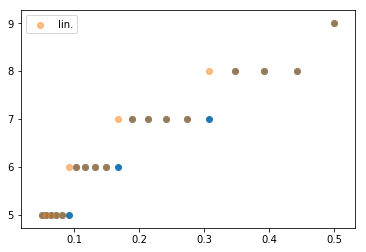

In [80]:
num = 20
n_min = 5
N_vals = [int(i) for i in np.logspace(np.log10(n_min),np.log10(9), num)]
N_vals_lin = [int(i) for i in np.linspace(n_min,9, num)]
pialphas = np.logspace(np.log10(0.05), np.log10(0.5), num)
print N_vals, pialphas
plt.scatter(pialphas, N_vals)
plt.scatter(pialphas, N_vals_lin, label='lin.', alpha=0.5)
plt.legend()
plt.show()

In [28]:
pialphast, populationst, paramst, N_valst = alpha_dependence(bias=50., w_2=2000., V = 100., num_cpus=3)

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 223.60679775.
The operators took 4.18993997574 and have dimension 104.
Building the RC Liouvillian took 4.209 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 10.7537369728 seconds.
6  N= 6
full steady states took 11.170 seconds
The operators took 4.19157195091 and have dimension 104.
Building the RC Liouvillian took 4.197 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 10.7460970879 seconds.
7  N= 6
full steady states took 12.147 seconds
The operators took 4.19356179237 and have dimension 104.
Building the RC Liouvillian took 4.211 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 10.7

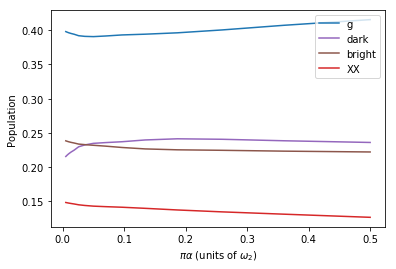

In [45]:
_, _ = population_alpha_dependence_plotter(8, eig=True)

## Parameters
Choose somes basic parameter regimes to use
- we want the gap to be larger than room phonon temperature and the same for both hetero and homodimer. This will show the differences in exciton population given the change in phonon-coupling for the same exciton energies but with different "darkness" and "brightness" (weaker in the hetero).
- WE can then cool down the phonons to turn off dark-state protection. Also look at coherence discrepancies.

In [82]:
print 300*0.695
eps, V = 50, 100
hetero_gap = eta_f(eps, V)
homo_V =  eta_f(eps, V)/2
homo_gap = eta_f(0., eta_f(eps, V)/2)
print hetero_gap, homo_V, homo_gap
print N_across_gap(2000., hetero_gap)

208.5
206.155281281 103.07764064 206.155281281
9



### Phonon bath parameters
- Changing the peak position will allow the phonons to couple to the gap, causing transitions. Though, the phonons may not have enough thermal energy to cause upwards transitions. This means that for dark state protection, we need a broad or **resonant phonon bath** with thermal energy smaller than the energy gap.

### Dimer electronic parameters
#### one heterodimers: with medium energy gap: $V>\epsilon$ .
- We can change the phonon temperature to turn off and on dark-state protection.
- More interesting regime as the bare excitonic states will be fully delocalised which 

#### one homodimer with same gap as hetero. (larger than thermal phonon energy at room T).
$V_{homo} = \eta/2$
- Totally dark and bright states. The dark state is only populated via mixing due to the phonons and due to dephasing which destroys the dark state (same thing?). We should see that for weak phonons the dark state is populated less highly than at stronger coupling.

- **Q: do the effects of the two baths add up?** Perhaps two-phonon processes could occur if the frequency is half that of the eta.

In [23]:
eps, V = 50, 100
homo_V =  eta_f(eps, V)/2
T_room = 300.
T_cool = 100.
#pialphas1, populations1, params1, N_vals1 = alpha_dependence(bias=eps, w_2=2000., V = V, T_ph = T_room,
#                                                             num=20, lower_N=5, num_cpus=3)
pialphas2, populations2, params2, N_vals2 = alpha_dependence(bias=eps, w_2=2000., V = V, T_ph = T_cool,
                                                             num=20, lower_N=5, num_cpus=3)
#pialphas3, populations3, params3, N_vals3 = alpha_dependence(bias=0., w_2=2000., V = homo_V, 
#                                                             num=20, lower_N=5, num_cpus=3)


Gap is 206.155281281. Phonon thermal energy is 69.5. Phonon SD peak is 206.155281281.
The operators took 6.65596795082 and have dimension 104.
Building the RC Liouvillian took 6.672 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 19.6212460995 seconds.
6  N= 6
full steady states took 33.511 seconds
The operators took 7.59113812447 and have dimension 104.
Building the RC Liouvillian took 7.609 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 20.3003089428 seconds.
7  N= 6
full steady states took 28.830 seconds
The operators took 7.2895359993 and have dimension 104.
Building the RC Liouvillian took 7.305 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 20.7

bias=50, V = 100, eta = 206.155281281 


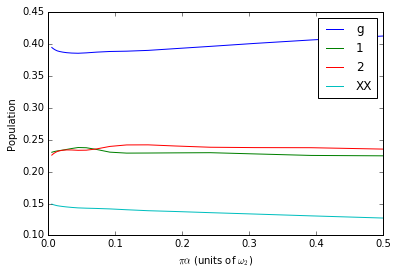

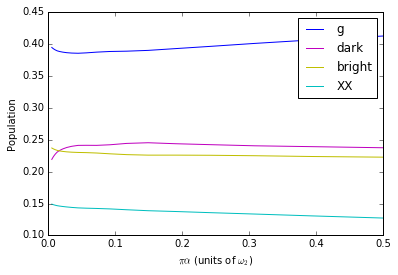

bias=50, V = 100, eta = 206.155281281 


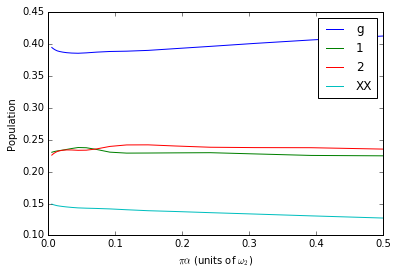

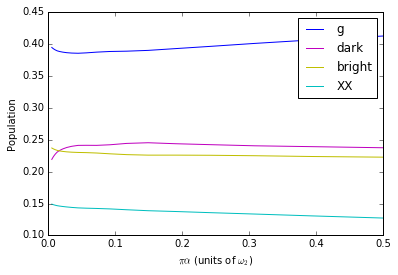

bias=0, V = 103.07764064, eta = 206.155281281 


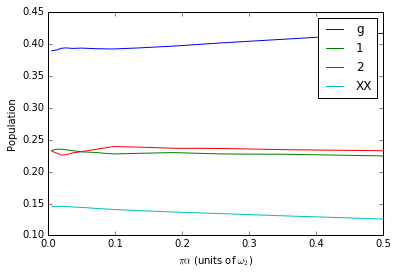

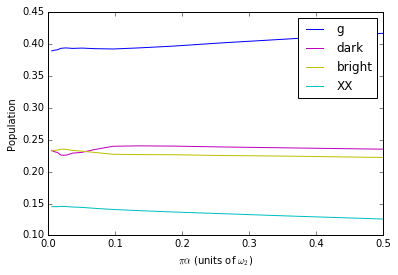

In [8]:
print "bias=50, V = 100, eta = {} ".format(sqrt(50**2 +4*(100**2)))
pa1, p1 = population_alpha_dependence_plotter(9)
pa1, p1 = population_alpha_dependence_plotter(9, eig=True)
print "bias=50, V = 100, eta = {} ".format(sqrt(50**2 +4*(100**2)))
pa1, p1 = population_alpha_dependence_plotter(10)
pa1, p1 = population_alpha_dependence_plotter(10, eig=True)
print "bias=0, V = {}, eta = {} ".format(homo_V, homo_V*2)
pa1, p1 = population_alpha_dependence_plotter(1)
pa1, p1 = population_alpha_dependence_plotter(1, eig=True)

In [40]:
pialphas, populations = populations_alpha_dependence(num=15, lower_N=7, upper_N=9, num_cpus=3)

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 140.0.
The operators took 7.99551606178 and have dimension 136.
Building the RC Liouvillian took 8.004 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Full optical Liouvillian took 19.9804120064 seconds.
1  N= 7
full steady states took 35.243 seconds
The operators took 8.12072110176 and have dimension 136.
Building the RC Liouvillian took 8.128 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Full optical Liouvillian took 20.0227119923 seconds.
2  N= 7
full steady states took 37.476 seconds
The operators took 8.21633005142 and have dimension 136.
Building the RC Liouvillian took 8.223 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Full optical Liouvillian took 20.20491790

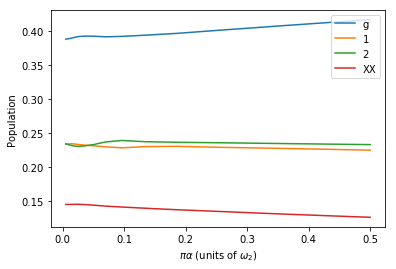

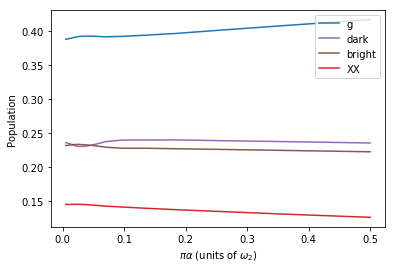

In [41]:
pa1, p1 = alpha_dependence_plotter(pialphas, populations)
pa1, p1 = alpha_dependence_plotter(pialphas, populations, eig=True)

### Coherences
Why?
- We are going to relate steadystate eigenstate coherences to the site basis coherence and population differences
- Seeing any maxima of coherence would be interesting (after shifts are accounted for)

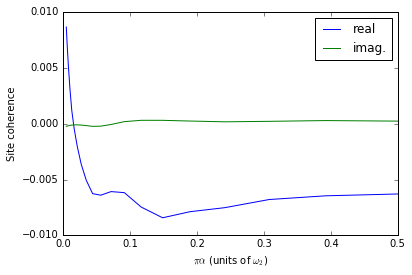

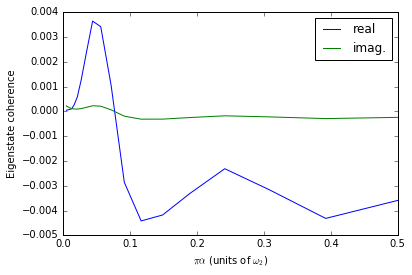

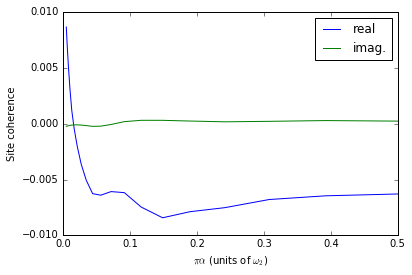

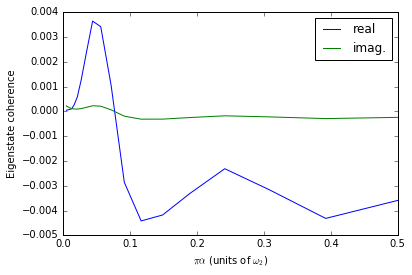

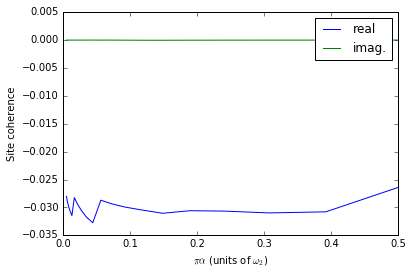

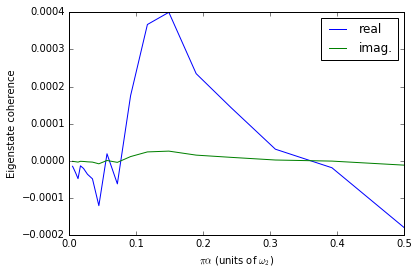

In [21]:
pa1, p1 = coherence_alpha_dependence_plotter(9)
pa1, p1 = coherence_alpha_dependence_plotter(9, eig=True)
pa1, p1 = coherence_alpha_dependence_plotter(10)
pa1, p1 = coherence_alpha_dependence_plotter(10, eig=True)
pa1, p1 = coherence_alpha_dependence_plotter(11)
pa1, p1 = coherence_alpha_dependence_plotter(11, eig=True)

In [139]:
dat1 = []
dat1.append(plot_dynamics(bias=0., w_2=4000., V = 100., N=6, 
                          alpha_1=50., alpha_2=50., T_EM=0., 
                          T_ph =300., alpha_EM=1., dimer_init='dark'))


The operators took 18.6476781368 and have dimension 104.
Building the RC Liouvillian took 19.333 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
0.0 0.0
Full optical Liouvillian took 11.8200778961 seconds.
10.0%. Run time:  11.30s. Est. time left: 00:00:01:41
20.0%. Run time:  22.92s. Est. time left: 00:00:01:31
30.0%. Run time:  34.64s. Est. time left: 00:00:01:20
40.0%. Run time:  46.41s. Est. time left: 00:00:01:09
50.0%. Run time:  58.98s. Est. time left: 00:00:00:58
60.0%. Run time:  71.11s. Est. time left: 00:00:00:47
70.0%. Run time:  83.27s. Est. time left: 00:00:00:35
80.0%. Run time:  95.52s. Est. time left: 00:00:00:23
90.0%. Run time: 107.68s. Est. time left: 00:00:00:11
Total run time: 119.78s
full dynamics took 119.990 seconds
It took 0.0395460128784 seconds to build the phenomenological Liouvillian
additive dynamics took 28.372 seconds
Full optical Liouvillian took 10.0598468781 seconds.
a

In [37]:
reload(opt)
def coherences_alpha_dependence(bias=100., w_2=2000., V = 100., 
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                lower_prop=0.005, upper_prop=0.5, 
                                 num=15, lower_N=3, upper_N=15, num_cpus=1):
    gap = sqrt(bias**2 +4*(V**2))
    phonon_energy = T_ph*0.695
    
    OO = basis(4,0)
    XO = basis(4,1)
    OX = basis(4,2)
    XX = basis(4,3)
    sigma_m1 = OX*XX.dag() + OO*XO.dag()
    sigma_m2 = XO*XX.dag() + OO*OX.dag()
    sigma_x1 = sigma_m1+sigma_m1.dag()
    sigma_x2 = sigma_m2+sigma_m2.dag()
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = 300., 300. # Phonon bath temperature

    wc = 1*53.08 # Ind.-Boson frame phonon cutoff freq
    Gamma_1, Gamma_2 = 50., 50.
    w0_2, w0_1 = w_2*0.07, w_2*0.07 # underdamped SD parameter omega_0
    w_xx = w_2 + w_1
    print "Gap is {}. Phonon thermal energy is {}. Phonon SD peak is {}.".format(gap, phonon_energy, w0_2)
    I_dimer = qeye(4)

    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2', 'wc',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    '''Defining DM states'''
    

    #Now we build all of the mapped operators and RC Liouvillian.

    # electromagnetic bath liouvillians

    opts = qt.Options(num_cpus=1, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    N_vals = [int(i) for i in np.logspace(np.log10(lower_N),np.log10(upper_N), num)]
    pialphas = np.logspace(np.log10(lower_prop), np.log10(upper_prop), num)
    populations = []
    
    for i, pialpha in enumerate(pialphas):
        alpha = w_2*pialpha/pi
        N_1 = N_2 = N = N_vals[i]
        silent = False
        if N<5:
            silent = True
        exc = N
        PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
        PARAMS.update({'N_1': N_1, 'N_2': N_2})
        PARAMS.update({'exc': exc})
        I = enr_identity([N_1,N_2], exc)
        ''' generate the RC liouvillian '''
        # Get the mapped parameters back
        L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                                silent=silent, 
                                                                shift=True)
        site_coherence = tensor(OX*XO.dag(), I)
        OO_proj = tensor(OO*OO.dag(), I)
        XO_proj = tensor(XO*XO.dag(), I)
        OX_proj = tensor(OX*OX.dag(), I)
        XX_proj = tensor(XX*XX.dag(), I)
        # dark and bright states defined without shifts
        energies, states = exciton_states(PARAMS, shift=False) 
        bright_vec = states[1]
        dark_vec = states[0]
        
        exciton_coherence = tensor(dark_vec*bright_vec.dag(), I)

        wRC_1, wRC_2 =  PARAMS['w0_1'], PARAMS['w0_2']
        kappa_1, kappa_2 = PARAMS['kappa_1'],PARAMS['kappa_2']
        ''' make the RC observable operators '''

        opts = qt.Options(num_cpus=num_cpus, store_states=True)

        #timelist = np.linspace(0,3,1000)
        e_ops = [OO_proj, XO_proj, OX_proj, XX_proj, dark, bright]
        timelist = np.linspace(0,0.6,10000)
        options = qt.solver.Options(nsteps=1500)
        L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
        ti = time.time()
        L = L_RC+L_EM_full
        if N >5:
            print i+1, " N=",N
            method='iterative-lgmres'
            use_precond = True
            ff=100
            dt=1e-4
            if N>7:
                ff = 50
                dt = 1e-3
                if N>9:
                    ff = 30
                    dt = 1e-2
        else:
            method = 'direct'
            use_precond = False
            ff=100
            dt=1e-4
        ss = steadystate(H[1], [L], method=method, use_precond=use_precond,
                                                 fill_factor=ff, drop_tol=dt)
        dat = []
        for e_op in e_ops:
            dat.append((e_op*ss).tr())
        populations.append(dat)
        if not silent:
            print "full steady states took {:0.3f} seconds".format(time.time()-ti)

    return pialphas, populations

def alpha_dependence_plotter(pialphas, populations, eig=False):
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['g', '1', '2', 'XX']
    ids = [0,1,2,3]
    if eig:
        labels = ['g', 'dark', 'bright', 'XX']
        ids = [0,4,5,3]
    populations = np.array(populations).T
    for i, l in zip(ids, labels):
        plt.plot(pialphas, populations[i], label=l, color=colors[i])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(r'Population')
    plt.legend()
    plt.show()
    return pialphas, populations

## Dark state protection

In [141]:
print np.sqrt(0**2 + 4*(100**2))
print 4000.*0.07
print 300.*0.695


200.0
280.0
208.5


Can the phonons overcome the dark-bright state gap? 

The phonons couple strongly to transitions on the same order as the splitting. The phonons also have enough thermal energy to overcome the gap. Try increasing the gap to see if the dark-state population is suppressed.

In [142]:
print np.sqrt(0**2 + 4*(200**2))
print 4000.*0.07
print 300.*0.695

400.0
280.0
208.5


In [143]:
dat2 = []
dat2.append(plot_dynamics(bias=0., w_2=4000., V = 200., N=6, 
                          alpha_1=50., alpha_2=50., T_EM=0., 
                          T_ph =300., alpha_EM=1., dimer_init='dark'))

The operators took 19.8447618484 and have dimension 104.
Building the RC Liouvillian took 20.535 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
0.0 0.0
Full optical Liouvillian took 11.9835619926 seconds.
10.0%. Run time:  12.25s. Est. time left: 00:00:01:50
20.0%. Run time:  24.55s. Est. time left: 00:00:01:38
30.0%. Run time:  37.77s. Est. time left: 00:00:01:28
40.0%. Run time:  51.42s. Est. time left: 00:00:01:17
50.0%. Run time:  63.81s. Est. time left: 00:00:01:03
60.0%. Run time:  76.67s. Est. time left: 00:00:00:51
70.0%. Run time:  90.89s. Est. time left: 00:00:00:38
80.0%. Run time: 104.18s. Est. time left: 00:00:00:26
90.0%. Run time: 117.89s. Est. time left: 00:00:00:13
Total run time: 131.20s
full dynamics took 131.411 seconds
It took 0.0400681495667 seconds to build the phenomenological Liouvillian
additive dynamics took 33.155 seconds
Full optical Liouvillian took 11.8388538361 seconds.
a

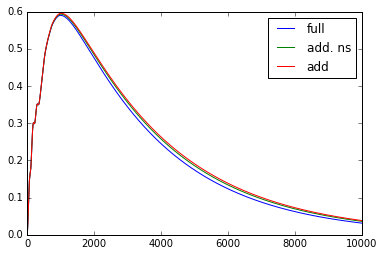

In [144]:

"""for d in dat:
    
    for i, l in enumerate(d):
        plt.plot(l.expect[1].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()"""
plt.figure()
for d in dat2:
    for i, l in enumerate(d):
        plt.plot(l.expect[4].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()
plt.show()

In [133]:
print np.sqrt(400**2 + 4*(100**2))
print 4000.*0.07
print 300.*0.695

447.2135955
280.0
208.5


In [4]:
dat3 = []
dat3.append(plot_dynamics(bias=100., w_2=4000., V = 150., N=7, 
                          alpha_1=100., alpha_2=100., T_EM=6000., 
                          T_ph =300., alpha_EM=1., dimer_init='ground'))

The operators took 34.3376498222 and have dimension 136.
Building the RC Liouvillian took 35.975 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
100.0 100.0
Full optical Liouvillian took 33.5340120792 seconds.
10.0%. Run time:  43.80s. Est. time left: 00:00:06:34
20.0%. Run time:  89.34s. Est. time left: 00:00:05:57
30.0%. Run time: 129.85s. Est. time left: 00:00:05:02
40.0%. Run time: 170.15s. Est. time left: 00:00:04:15
50.0%. Run time: 210.50s. Est. time left: 00:00:03:30
60.0%. Run time: 250.98s. Est. time left: 00:00:02:47
70.0%. Run time: 291.38s. Est. time left: 00:00:02:04
80.0%. Run time: 331.73s. Est. time left: 00:00:01:22
90.0%. Run time: 372.19s. Est. time left: 00:00:00:41
Total run time: 412.52s
full dynamics took 413.356 seconds
100.0 100.0
It took 0.0649590492249 seconds to build the phenomenological Liouvillian
additive dynamics took 73.491 seconds
Full optical Liouvillian took 17.68905

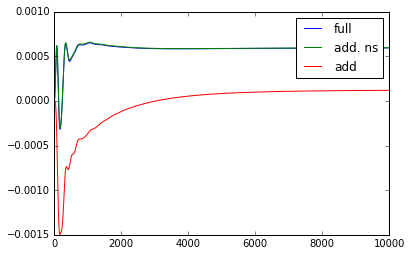

In [7]:

"""for d in dat:
    
    for i, l in enumerate(d):
        plt.plot(l.expect[1].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()"""
plt.figure()
for d in dat3:
    for i, l in enumerate(d):
        plt.plot(l.expect[1].imag, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()
plt.show()

In [20]:
dat = []
dat.append(plot_dynamics(bias=100., w_2=4000., V = 100., N=6, 
                          alpha_1=30., alpha_2=30., T_EM=0., 
                          T_ph =300., alpha_EM=1.))

The operators took 18.3629541397 and have dimension 104.
Building the RC Liouvillian took 19.004 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
47.1238898038
dynamics took 82.425 seconds


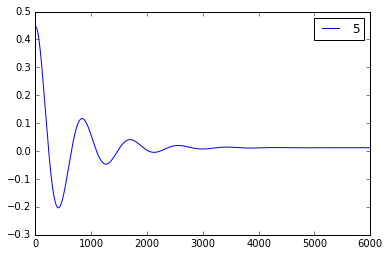

In [21]:
l = iter(range(5,8))
for d in dat:
    plt.plot(d.expect[1].real, label=l.next())
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()
plt.show()

In [38]:
dat = []
for n in range(5,8):
    print "N={}".format(n)
    dat.append(plot_dynamics(bias=100., w_2=4000., V = 100., N=n, 
                  alpha_1=30., alpha_2=30., T_EM=0., 
                  T_ph =300., alpha_EM=1.))
    

N=5


KeyboardInterrupt: 

In [51]:
plot_dynamics(bias=100., w_2=4000., V = 100., N=8, 
                          alpha_1=30., alpha_2=30., T_EM=0., 
                          T_ph =300., alpha_EM=1.)

The operators took 63.578772068 and have dimension 172.
Building the RC Liouvillian took 67.220 seconds.
****************************************************************
It is 29584by29584. The full basis would be 65536by65536
[3938.1966011250106, 4161.8033988749894] [     0.            200.            200.            400.            400.
    400.            600.            600.            600.            600.
    800.            800.            800.            800.            800.
   1000.           1000.           1000.           1000.           1000.
   1000.           1200.           1200.           1200.           1200.
   1200.           1200.           1200.           1400.           1400.
   1400.           1400.           1400.           1400.           1400.
   1400.           1600.           1600.           1600.           1600.
   1600.           1600.           1600.           3994.74591193
   4145.14383728   4194.74592259   4261.18374568   4329.74670772
   4345.14415717  

In [35]:
3994.74 - 4032.44

-37.70000000000027

In [ ]:
46.2080

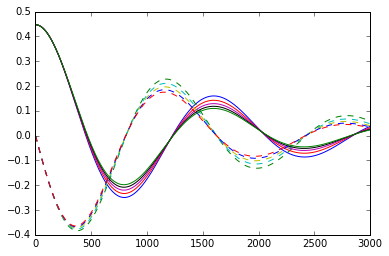

In [98]:
for d in dat:
    plt.plot(d.expect[1].real)
    plt.plot(d.expect[1].imag, ls='dashed')
plt.show()